## Shor v1.0 (release)

$U_f$ changes any "binary" state to the next. But there are eigenstates! What are they?

Eigenvector of Unitary gate:

$U_f|u\rangle=e^{i\phi}|u\rangle$

Let's prepare a state, such that:

$|\psi\rangle=\frac{1}{\sqrt{r}}(|f(0)\rangle+|f(2)\rangle+...+|f(r-1)\rangle)$

Then

$U_f|\psi\rangle=U_f \frac{1}{\sqrt{r}}(|f(0)\rangle+|f(2)\rangle+...+|f(r-1)\rangle)$

$U_f|\psi\rangle=\frac{1}{\sqrt{r}}(U_f|f(0)\rangle+U_f|f(2)\rangle+...+U_f |f(r-1)\rangle)$

$U_f|\psi\rangle=\frac{1}{\sqrt{r}}(|f(1)\rangle+|f(2)\rangle+...+|f(r-1)\rangle+|f(r)\rangle)$

$U_f|\psi\rangle=\frac{1}{\sqrt{r}}(|f(1)\rangle+|f(2)\rangle+...+|f(r-1)\rangle+|f(0)\rangle)$

$U_f|\psi\rangle=\frac{1}{\sqrt{r}}(|f(0)\rangle+|f(1)\rangle+...+|f(r-1)\rangle)=|\psi\rangle$

This, such $|\psi\rangle$ is an eigenstate with eigenvalue 1 (eigenphase 0). Boring. Anything more interesting?

Let's have arbitrary integer $s<r$, such that

$|\psi_s\rangle=\frac{1}{\sqrt{r}}\sum_{k=0}^{r-1}e^\frac{-2\pi isk}{r}|f(k)\rangle$

Each next state is rotated by $\frac{-2\pi s}{r}$ compared to previously, and finally all state close $s$ close full circles.

$U_f|\psi_s\rangle=\frac{1}{\sqrt{r}}\sum_{k=0}^{r-1}e^\frac{-2\pi isk}{r}U_f|f(k)\rangle$

$U_f|\psi_s\rangle=\frac{1}{\sqrt{r}}\sum_{k=0}^{r-1}e^\frac{-2\pi isk}{r}|f(k+1)\rangle$

$U_f|\psi_s\rangle=e^\frac{2\pi is}{r}\frac{1}{\sqrt{r}}\sum_{k=0}^{r-1}e^\frac{-2\pi isk}{r}|f(k)\rangle=e^\frac{2\pi is}{r}|\psi_s\rangle$

Thus, for such states there are distiguishable eigenphases. What if we prepare a superposition of all $|\psi_0\rangle...|\psi_{r-1}\rangle$?

for $t>1$ sum of state coefficients in front of the state cancels out: 

$\sum_{s=0}^{r-1}e^{-2i\pi sk/r}|f(t)\rangle=|f(t)\rangle\sum_{s=0}^{r-1}e^{-2i\pi sk/r}=|f(t)\rangle\sum_{s=-(r-1/2)}^{(r-1)/2}e^{-2i\pi sk/r}=$

$=|f(t)\rangle\left[\sum_{s=-(r-1/2)}^{-1}e^{-2i\pi sk/r}+\sum_{s=1}^{(r-1)/2}e^{-2i\pi sk/r}\right]=$

$=|f(t)\rangle\left[-\sum_{s=1}^{(r-1)/2}e^{-2i\pi sk/r}+\sum_{s=1}^{(r-1)/2}e^{-2i\pi sk/r}\right]=0|f(t)\rangle$

Only $|f(0)\rangle=|1\rangle$ remains.

**Result**. Superposition of all eigenstates with an eigenphase of $\frac{s}{r}$ is $|1\rangle$. If we apply QPE algorithm to this state, we will see the superposition of the binary "frequencies": $\frac{2^m*1}{r}, \frac{2^m*2}{r}, ..., \frac{2^m(r-1)}{r}$. Each of them measured with equal probability will approximate a proper fraction with $r$ in denominator.

Thus, Shor algorithm is nothing but:
- Prepare an eigenstate $|1\rangle$ for $U_f$.
- Run QPE once. Only [one shot](https://www.youtube.com/watch?v=_Yhyp-_hX2s).
- Approximate result of QPE with a proper fraction. Use denominator as $r$.
- Use $r$ to compute $p$, $q$.

## Let's do this in practice!

Sum everything up.

In [3]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram

In [6]:
def U_f(power):
    qc = QuantumCircuit(4, name=f"U^{power}f")
    import math
    # TODO: implement non-controlled 2^x mod 15 in a unitary form 

    
    return qc

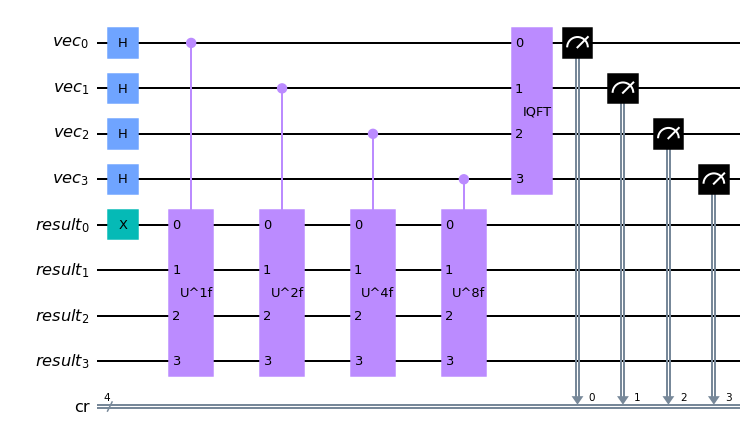

In [10]:
qvec = QuantumRegister(4, name="vec")  # eigenvector of U
qres = QuantumRegister(4, name="result")  # result register
cres = ClassicalRegister(4, name="cr") # binary result
qc = QuantumCircuit(qvec, qres, cres)

# TODO prepare equal superposition in qres


# TODO prepare an eigenvalue in qvec


for i in range(4):
    qc.append(U_f(2 ** i).to_gate().control(1),[qvec[i]] + qres[:])

# apply Inverse QFT to qvec
qc.append(QFT(4).inverse(), qvec)

qc.measure(qvec, cres)
qc.draw(output='mpl')

In [13]:
# !!!!!!!!!!!!!!!!!!!! ONE SHOT ONE OPPORTUNITY 
shots = 1
job = execute(qc, Aer.get_backend('qasm_simulator'), shots=shots)
counts = job.result().get_counts(qc)
print(counts)

{'1100': 1}


In [14]:
from fractions import Fraction

freq = int(counts.keys().__iter__().__next__(), base=2)

if freq == 0:
    print("Unlucky shot")
    
freq = freq / (2 ** 4)

freq = Fraction(freq).limit_denominator(1000)
print(freq)

r = freq.denominator

3/4


In [7]:
## TODO Complete the classical part (copy it from `130`).